In [15]:
import saflow
import os.path as op
import pickle as pkl
import numpy as np
import pandas as pd
import os
import mne_bids
import mne
from sklearn.model_selection import permutation_test_score, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

In [9]:
feature_name = 'psd_fooof_sensor_8trials'
feature_folder = f'/media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/{feature_name}'
for idx_subj, subj in enumerate(sorted(os.listdir(feature_folder))):
    for trial in os.listdir(op.join(feature_folder, subj, 'meg')):
        filepath = op.join(feature_folder, subj, 'meg', trial)
        with open(filepath, 'rb') as f:
            data = pkl.load(f)
        print(data['fooof'][0])
        0/0

ZeroDivisionError: division by zero

array([-25.71871601,  32.61252546,   1.66475155])

In [16]:
# Load the data
def load_features(feature_folder, feature='psd', splitby='inout', balance=False, inout='INOUT_2575'):
    ''' 0 = IN, 1 = OUT
    '''
    #picks, mag_info = get_meg_picks_and_info(subject='12', run='04')
    X = []
    y = []
    groups = []
    VTC = []
    for idx_subj, subj in enumerate(sorted(os.listdir(feature_folder))):
        for trial in os.listdir(op.join(feature_folder, subj, 'meg')):
            filepath = op.join(feature_folder, subj, 'meg', trial)
            with open(filepath, 'rb') as f:
                data = pkl.load(f)
            #trial_is_bad = check_if_bad_trial(data['info'], n=1, how='last_n')
            trial_is_bad = False
            if not trial_is_bad:
                if splitby == 'inout':
                    if type(data['info'][inout]) == str:
                        if data['info'][inout] == 'IN':
                            y.append(0)
                        elif data['info'][inout] == 'OUT':
                            y.append(1)
                        groups.append(idx_subj)

                        if feature in ['psd', 'lzc']:
                            X.append(data['data'])#[:,picks])

                        elif feature in ['slope', 'offset', 'r_squared', 'knee']:
                            temp_X = []
                            for fm in data['fooof']:
                                if feature == 'slope':
                                    temp_X.append(fm.get_params('aperiodic_params')[-1])
                                elif feature == 'offset':
                                    temp_X.append(fm.get_params('aperiodic_params')[0])
                                elif feature == 'knee':
                                    temp_X.append(fm.get_params('aperiodic_params')[1])
                                elif feature == 'r_squared':
                                    temp_X.append(fm.get_params('r_squared'))
                            X.append(np.array(temp_X))

                        VTC.append(data['info']['VTC'])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    VTC = np.array(VTC)
    return X, y, groups, VTC

def check_if_bad_trial(events_dict, n=1, how='last_n'):
    bad_trial_list = [int(x) for x in events_dict['included_bad_epochs']]
    if how == 'last_n':
        if np.sum(bad_trial_list[-n:])>1:
            return True
        else:
            return False
    elif how == 'more_than_n':
        if np.sum(bad_trial_list)>n:
            return True
        else:
            return False
    
# trial_is_bad = check_if_bad_trial(trial_idx, subject, run)

def get_meg_picks_and_info(subject, run, bids_root='/home/hyruuk/DATA/saflow/bids'):
    rawpath = mne_bids.BIDSPath(subject=subject, task='gradCPT', run=run, datatype='meg', suffix='meg', root=bids_root)
    raw = mne_bids.read_raw_bids(rawpath, verbose=False)
    picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False)
    raw_mag = raw.copy().pick_types(meg=True, ref_meg=False, eeg=False, eog=False)
    return picks, raw_mag.info


def singlefeat_classif(clf, cv, X, y, groups):
    clf = LinearDiscriminantAnalysis()
    cv = LeaveOneGroupOut()

    all_scores, all_perm_scores, all_pvals = [], [], []
    for freq_idx in range(X.shape[-2]):
        scores, perm_scores, pvals = [], [], []
        for chan_idx in range(X.shape[-1]):
            X_sf = X[:,freq_idx,chan_idx]
            score, permutation_scores, pvalue = permutation_test_score(clf, X=X_sf.reshape(-1, 1), y=y, groups=groups, cv=cv, n_permutations=1, n_jobs=-1)
            scores.append(score)
            perm_scores.append(permutation_scores)
            pvals.append(pvalue)
            print(f'Score {score}, pvalue {pvalue}')
        all_scores.append(scores)
        all_perm_scores.append(perm_scores)
        all_pvals.append(pvals)
        
    all_scores = np.array(all_scores)
    all_perm_scores = np.array(all_perm_scores)
    all_pvals = np.array(all_pvals)
    all_results = {'scores': all_scores, 'perm_scores': all_perm_scores, 'pvals': all_pvals}
    return all_results



def subject_average(X, y, groups):
    """Computes group-averages."""
    new_X = []
    new_y = []
    for subj in np.unique(groups):
        for cond in np.unique(y):
            new_X.append(X[(groups == subj) & (y == cond)].mean(axis=0))
            new_y.append(cond)
    new_X = np.array(new_X)
    new_y = np.array(new_y)
    return new_X, new_y

def simple_contrast(X, y, groups):
    """Computes subject-averages and contrasts between conditions."""
    X_avg, y_avg = subject_average(X, y, groups)
    # Average each condition separately
    X_avg_by_cond = []
    for cond in np.unique(y_avg):
        X_avg_by_cond.append(np.mean(X_avg[y_avg == cond], axis=0))
    # Compute normalized contrast (A - B)/B
    X_contrast = (X_avg_by_cond[0] - X_avg_by_cond[1]) / X_avg_by_cond[1]
    # Split conditions for ttest
    X_condA = X_avg[y_avg == 0]
    X_condB = X_avg[y_avg == 1]
    
    # Compute t-test
    tvals = []
    pvals = []
    for freq_idx in range(X.shape[1]):
        t, p = stats.ttest_rel(X_condA[:,freq_idx,:], X_condB[:,freq_idx,:], axis=0)
        tvals.append(t)
        pvals.append(p)
    tvals = np.array(tvals)
    pvals = np.array(pvals)
    return X_contrast, tvals, pvals

def array_topoplot(array_data, chan_info, title, masks=None, mask_params=None, cmap='magma', vlim=(-1,1)):
    if masks is not None:
        if mask_params is None:
            mask_params = dict(
                marker="o", markerfacecolor="w", markeredgecolor="k", linewidth=0, markersize=5
            )
    fig, axes = plt.subplots(1, array_data.shape[0], figsize=(20, 7))
    for idx, ax in enumerate(axes.flatten()):
        mne.viz.plot_topomap(array_data[idx,:], 
                            chan_info, 
                            axes=ax, 
                            show=False, 
                            cmap=cmap,
                            mask=masks[idx,:] if masks is not None else None,
                            mask_params=mask_params,
                            vlim=vlim,
                            extrapolate="box",
                            outlines="head",
                            sphere=0.15,
                            contours=0,
        )
        ax.set_title(saflow.FREQS_NAMES[idx])
    # Add a colorbar and title. For this we need to use the figure handle.
    fig.colorbar(axes[0].images[-1], ax=axes.tolist(), orientation='vertical', fraction=.006)
    if title is not None:
        fig.suptitle(title, y=0.75)
    return fig, axes




NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.


/tmp/ipykernel_60959/4102689146.py:50: RuntimeWarning: The unit for channel(s) HADC001-3105, HADC002-3105, HADC003-3105, HDAC001-3105, HDAC002-3105, HDAC003-3105, HLC0011-2104, HLC0012-2104, HLC0013-2104, HLC0014-2104, HLC0015-2104, HLC0016-2104, HLC0017-2104, HLC0018-2104, HLC0021-2104, HLC0022-2104, HLC0023-2104, HLC0024-2104, HLC0025-2104, HLC0026-2104, HLC0027-2104, HLC0028-2104, HLC0031-2104, HLC0032-2104, HLC0033-2104, HLC0034-2104, HLC0035-2104, HLC0036-2104, HLC0037-2104, HLC0038-2104, SCLK01-177 has changed from V to NA.
  raw = mne_bids.read_raw_bids(rawpath, verbose=False)


(<Figure size 2000x700 with 9 Axes>,
 array([<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'lobeta'}>,
        <Axes: title={'center': 'hibeta'}>,
        <Axes: title={'center': 'gamma1'}>,
        <Axes: title={'center': 'gamma2'}>,
        <Axes: title={'center': 'gamma3'}>], dtype=object))

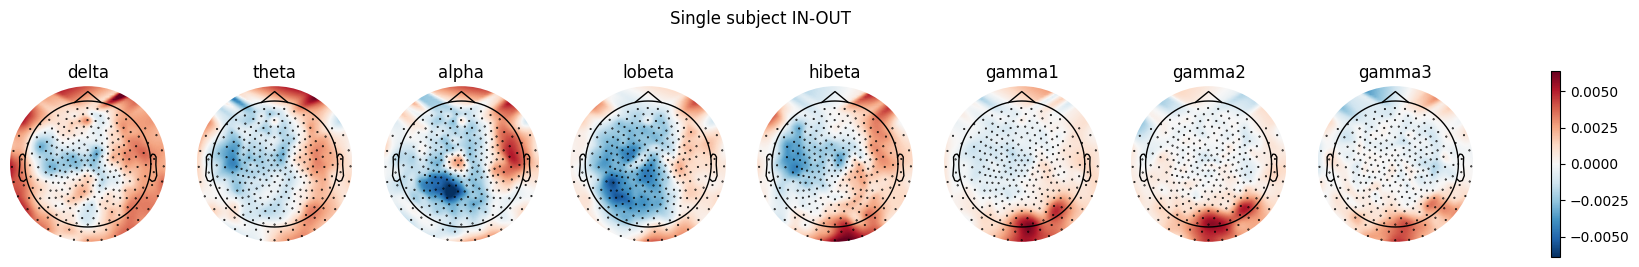

In [9]:
feature_name = 'psd_fooof_sensor_8'
feature_folder = f'/media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/{feature_name}'
X, y, groups, VTC = load_features(feature_folder, inout='INOUT_2575')
picks, chan_info = get_meg_picks_and_info('12', '02')
X = X[:,picks,:]
X_contrast, tvals, pvals = simple_contrast(X, y, groups)
lim = np.max(abs(X_contrast))
array_topoplot(X_contrast.T, chan_info, cmap='RdBu_r', title='Single subject IN-OUT', vlim=(-lim, lim))

In [22]:
## Load data
feature_name = 'psd_welch_sensor_8'
feature_folder = f'/media/hyruuk/YH_storage/DATA/saflow/bids/derivatives/{feature_name}'
X, y, groups, VTC = load_features(feature_folder, inout='INOUT_2575')
picks, chan_info = get_meg_picks_and_info('12', '02')
X_contrast, tvals, pvals = simple_contrast(X, y, groups)
lim = np.max(abs(X_contrast))


KeyboardInterrupt: 

(<Figure size 2000x700 with 9 Axes>,
 array([<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'lobeta'}>,
        <Axes: title={'center': 'hibeta'}>,
        <Axes: title={'center': 'gamma1'}>,
        <Axes: title={'center': 'gamma2'}>,
        <Axes: title={'center': 'gamma3'}>], dtype=object))

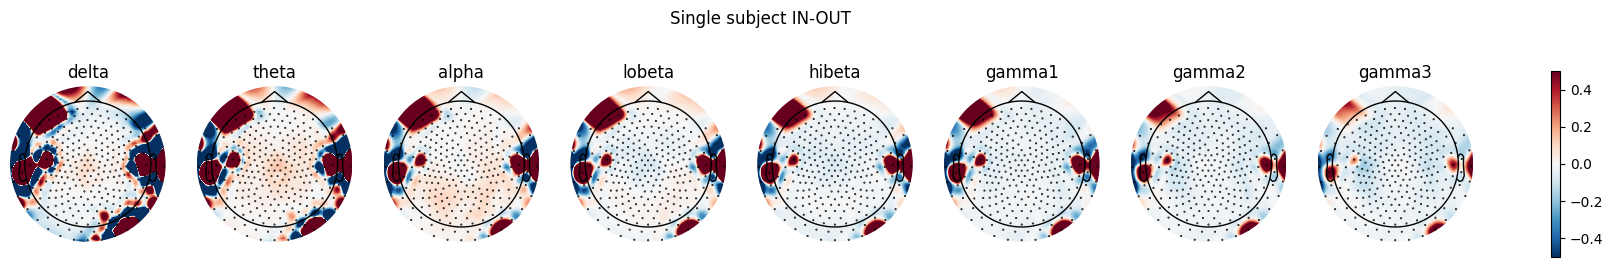

In [25]:
array_topoplot(X_contrast[:,picks], chan_info, cmap='RdBu_r', title='Single subject IN-OUT', vlim=(-0.5, 0.5))

In [14]:
# Classif SF
output_filename = f'../tmp/lda_inout2575_{feature_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X, y, groups)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

NameError: name 'singlefeat_classif' is not defined

array([[0.50250987, 0.5027088 , 0.50149695, ..., 0.5014515 , 0.50165515,
        0.50351596],
       [0.50152597, 0.50486135, 0.50093284, ..., 0.50080427, 0.50072898,
        0.50842766],
       [0.5008775 , 0.49935752, 0.49965483, ..., 0.50407932, 0.50292301,
        0.5101415 ],
       ...,
       [0.50338689, 0.507641  , 0.50635415, ..., 0.50795281, 0.50500354,
        0.50358805],
       [0.50269136, 0.50169275, 0.50556747, ..., 0.50252327, 0.50265313,
        0.50661068],
       [0.50161733, 0.50189683, 0.50586198, ..., 0.50492757, 0.50283531,
        0.50572139]])

## Stats

(<Figure size 2000x700 with 9 Axes>,
 array([<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'lobeta'}>,
        <Axes: title={'center': 'hibeta'}>,
        <Axes: title={'center': 'gamma1'}>,
        <Axes: title={'center': 'gamma2'}>,
        <Axes: title={'center': 'gamma3'}>], dtype=object))

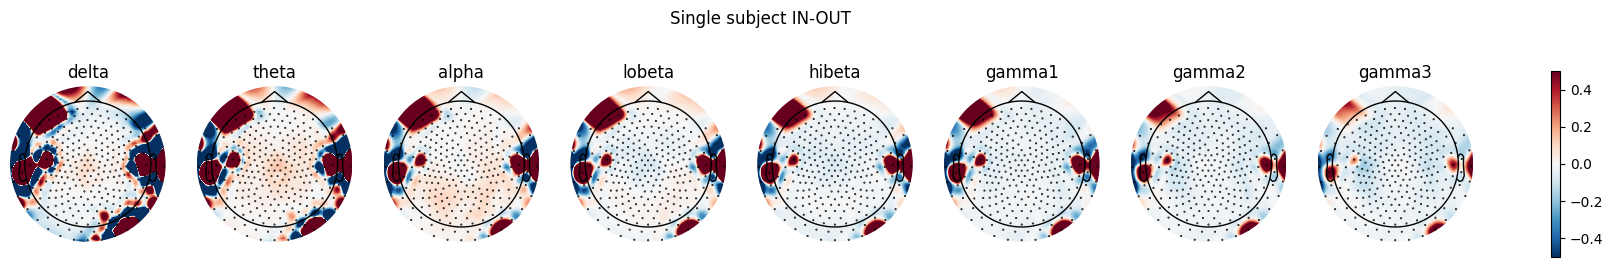

In [28]:
## Single subject
X_contrast, tvals, pvals = simple_contrast(X, y, groups)
lim = np.max(abs(X_contrast))
array_topoplot(X_contrast[:,picks], chan_info, cmap='RdBu_r', title='Single subject IN-OUT', vlim=(-0.5, 0.5))

In [29]:
# FDR correction
from statsmodels.stats.multitest import fdrcorrection
qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])

# Create significance mask
def mask_pvals(pvals, alpha):
    return pvals < alpha

pvals_masks = np.array([mask_pvals(pvals[x,:], 0.001) for x in range(pvals.shape[0])])


In [32]:
# load new_allfreq
with open('../tmp/lda_inout2575_sensor_1.pkl', 'rb') as f:
    decoding_accuracies = pkl.load(f)
    #new_allfreq = data['scores']

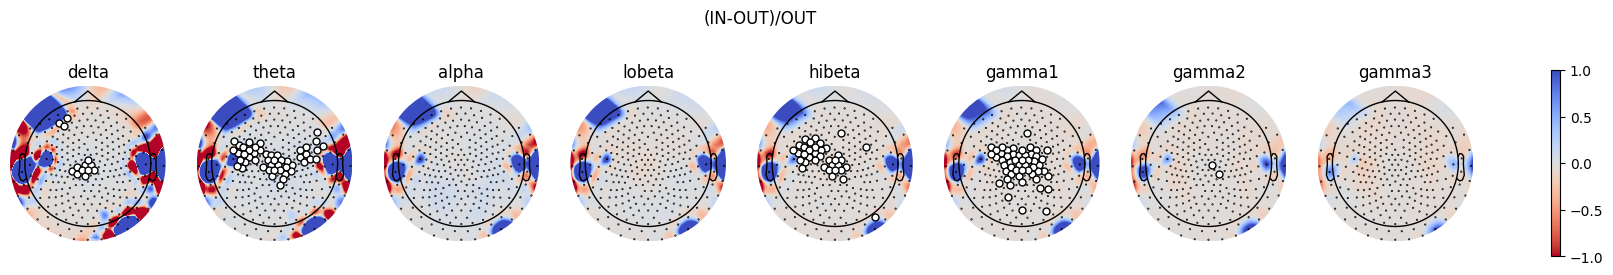

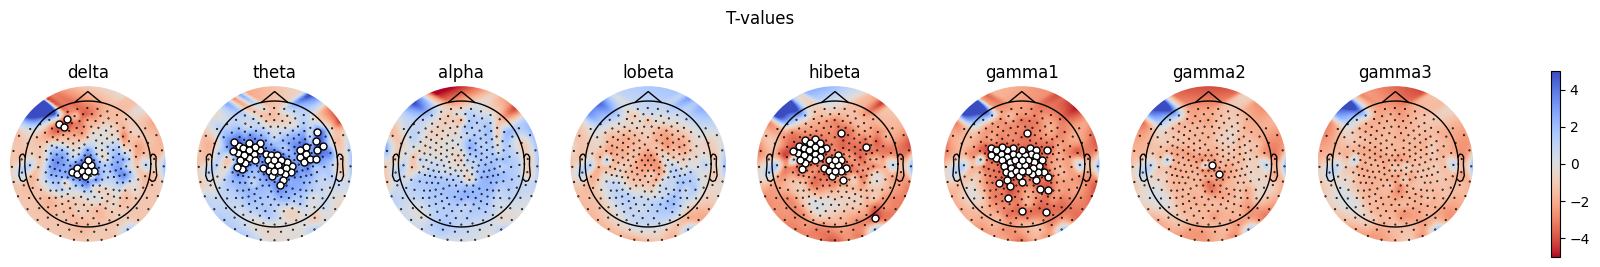

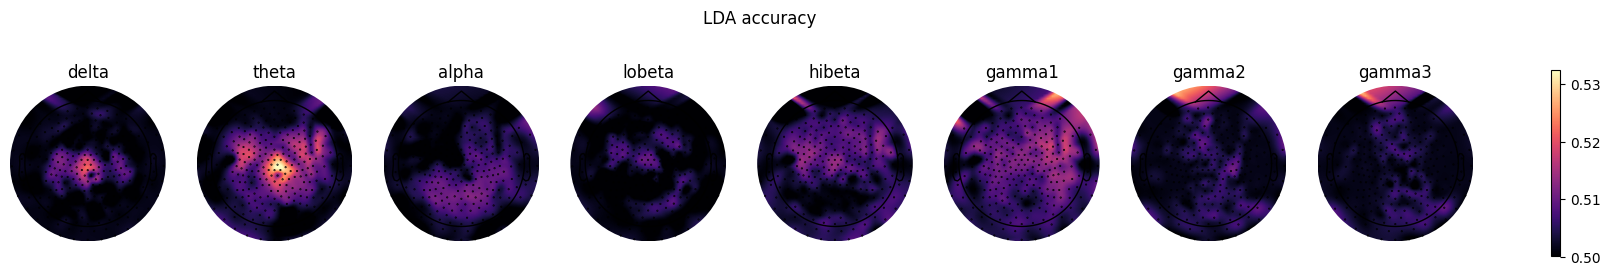

In [34]:



fig1, axes2 = array_topoplot(X_contrast[:,picks], chan_info, masks=pvals_masks[:,picks], cmap='coolwarm_r', title='(IN-OUT)/OUT')
fig2, axes2 = array_topoplot(tvals[:,picks], chan_info, cmap='coolwarm_r', masks=pvals_masks[:,picks], title='T-values', vlim=(-5,5))
fig3, axes3 = array_topoplot(decoding_accuracies, chan_info, cmap='magma', title='LDA accuracy', vlim=(0.5,max(decoding_accuracies.flatten())))





In [213]:
from PIL import Image
def combine_images(fig1, fig2, fig3):
    # Assuming you have three figures fig1, fig2, fig3
    fig1.savefig('../tmp/tmp_fig1.png', bbox_inches='tight')
    fig2.savefig('../tmp/tmp_fig2.png', bbox_inches='tight')
    fig3.savefig('../tmp/tmp_fig3.png', bbox_inches='tight')

    # Open the images
    img1 = Image.open('../tmp/tmp_fig1.png')
    img2 = Image.open('../tmp/tmp_fig2.png')
    img3 = Image.open('../tmp/tmp_fig3.png')

    # Assuming all images are the same size
    width, height = img1.size

    # Create a new image with a height to accommodate all three images
    total_height = height * 3
    combined_img = Image.new('RGB', (width, total_height))

    # Combine images by pasting them one below the other
    y_offset = 0
    for img in [img1, img2, img3]:
        combined_img.paste(img, (0, y_offset))
        y_offset += height

    # Add a title to the combined image if needed using ImageDraw

    # Save the combined image
    combined_img.save('../reports/combined_topomaps_PSD_8trials.png')

    # Display the combined image (for example, in a Jupyter notebook)
    combined_img.show()
    return combined_img
combined_img = combine_images(fig1, fig2, fig3)

In [84]:
max(array_data[:,:].flatten())

62.00858957801199